In [8]:
import ccxt
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import pyinform.transferentropy as te  # may fail on some systems
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# user-editable parameters
# ==========================================
# 1. CONFIGURATION FOR 5-MINUTE DATA
# ==========================================
COINS = ["BTC/USDT", "ETH/USDT", "SOL/USDT", "MATIC/USDT", "AVAX/USDT", "LINK/USDT", "APT/USDT"]
EXCHANGE_ID = 'binance'

# CHANGE 1: Timeframe
TIMEFRAME = '5m'   

# CHANGE 2: Reduce History
# 180 days of 5m data = ~51,000 rows. This is heavy. 
# 60 days is usually enough for lead-lag analysis on high frequency.
SINCE_DAYS = 60    

# CHANGE 3: Adjust Lags
# On 1h data, Lag 12 = 12 Hours.
# On 5m data, Lag 12 = 1 Hour (12 * 5m).
# To look back 2 hours, you need 24 lags.
MAX_LAG_STEPS = 24 # hours for rolling correlation if needed


In [9]:
def fetch_ohlcv(exchange, symbol, timeframe='1h', since=None, limit=1000):
    # returns a DataFrame with columns: datetime, open, high, low, close, volume
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp','open','high','low','close','volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    df = df[['open','high','low','close','volume']]
    return df

# initialize exchange
exchange = getattr(ccxt, EXCHANGE_ID)({
    'enableRateLimit': True,
    # 'options': {'defaultType': 'future'}  # enable if you want futures
})

# fetch for all coins (loop - respects rate limits)
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=SINCE_DAYS)
since_ms = int(start_time.timestamp() * 1000)

all_data = {}
for sym in tqdm(COINS, desc="Fetching"):
    # Binance max limit per call depends on timeframe; loop if needed
    df_list = []
    since = since_ms
    while True:
        chunk = fetch_ohlcv(exchange, sym, TIMEFRAME, since=since, limit=1000)
        if chunk.empty:
            break
        df_list.append(chunk)
        last = chunk.index[-1]
        # next since: last timestamp + 1ms
        since = int((last + pd.Timedelta(milliseconds=1)).timestamp() * 1000)
        if (last >= end_time - pd.Timedelta(minutes=1)) or len(chunk) < 1000:
            break
        time.sleep(exchange.rateLimit/1000)  # rate limit handling
    if df_list:
        df = pd.concat(df_list)
        df = df[~df.index.duplicated(keep='first')]
        all_data[sym] = df
    else:
        print(f"No data for {sym}")

# quick check
for k,v in all_data.items():
    print(k, v.index.min(), v.index.max(), len(v))


Fetching:   0%|          | 0/7 [00:00<?, ?it/s]

No data for MATIC/USDT
BTC/USDT 2025-09-19 09:20:00 2025-11-18 14:45:00 17346
ETH/USDT 2025-09-19 09:20:00 2025-11-18 14:45:00 17346
SOL/USDT 2025-09-19 09:20:00 2025-11-18 14:45:00 17346
AVAX/USDT 2025-09-19 09:20:00 2025-11-18 14:45:00 17346
LINK/USDT 2025-09-19 09:20:00 2025-11-18 14:45:00 17346
APT/USDT 2025-09-19 09:20:00 2025-11-18 14:45:00 17346


In [10]:
# ============================================
# 1. Determine correct pandas frequency
# ============================================
if TIMEFRAME.endswith("m"):
    freq = TIMEFRAME.upper().replace("M", "T")  # pandas minute = 'T'
elif TIMEFRAME.endswith("h"):
    freq = TIMEFRAME.upper()  # '1h' -> '1H'
elif TIMEFRAME.endswith("d"):
    freq = TIMEFRAME.upper()
else:
    raise ValueError("Unsupported timeframe:", TIMEFRAME)

# ============================================
# 2. Build clean continuous index
# ============================================
all_starts = []
all_ends = []

for sym, df in all_data.items():
    all_starts.append(df.index.min())
    all_ends.append(df.index.max())

start = min(all_starts)
end   = max(all_ends)

# clean continuous hourly index
common_index = pd.date_range(start=start, end=end, freq=freq)

# ============================================
# 3. Build prices + volumes aligned to this index
# ============================================
prices = pd.DataFrame(index=common_index)
volumes = pd.DataFrame(index=common_index)

for sym, df in all_data.items():
    # resample each coin to the same freq BEFORE aligning
    p = df['close'].resample(freq).last()
    v = df['volume'].resample(freq).sum()

    # align onto common_index
    p = p.reindex(common_index).ffill()
    v = v.reindex(common_index).fillna(0)

    prices[sym] = p
    volumes[sym] = v

print("Prices shape:", prices.shape)
display(prices.head())

# compute log returns
rets = np.log(prices / prices.shift(1)).dropna(how='all')

for col in rets.columns:
    rets[col] = pd.to_numeric(rets[col], errors="coerce").astype(float)

rets = rets.replace([np.inf, -np.inf], np.nan)
rets = rets.dropna(how="all")
rets = rets.fillna(0)

print("Returns cleaned — dtypes:")
print(rets.dtypes)



Prices shape: (17346, 6)


,BTC/USDT,ETH/USDT,SOL/USDT,AVAX/USDT,LINK/USDT,APT/USDT
2025-09-19 09:20:00,116886.89,4541.72,243.74,34.26,24.64,4.688
2025-09-19 09:25:00,116825.19,4531.92,242.94,34.17,24.51,4.667
2025-09-19 09:30:00,116881.59,4539.83,243.28,34.24,24.56,4.681
2025-09-19 09:35:00,116830.36,4534.74,243.17,34.17,24.51,4.661
2025-09-19 09:40:00,116712.30,4527.79,242.69,34.06,24.41,4.634


Returns cleaned — dtypes:
BTC/USDT     float64
ETH/USDT     float64
SOL/USDT     float64
AVAX/USDT    float64
LINK/USDT    float64
APT/USDT     float64
dtype: object


In [11]:
def lagged_corr_matrix(returns_df, max_lag=12):
    symbols = returns_df.columns.tolist()
    corr_tensor = {}
    rows = []   # instead of append to DataFrame

    for L in range(1, max_lag+1):
        corr_df = pd.DataFrame(index=symbols, columns=symbols, dtype=float)
        for a in symbols:
            for b in symbols:
                if a == b:
                    corr_df.loc[a, b] = np.nan
                    continue
                a_series = returns_df[a].dropna()
                b_series = returns_df[b].dropna()

                # align and shift b backward by L → correlation r(a(t), b(t+L))
                joined = pd.concat([a_series, b_series.shift(-L)], axis=1).dropna()

                if len(joined) < 10:
                    corr_df.loc[a, b] = np.nan
                else:
                    corr_df.loc[a, b] = joined.corr().iloc[0, 1]

        corr_tensor[L] = corr_df

    # Build best-lag table (faster + no append)
    for a in symbols:
        for b in symbols:
            if a == b:
                continue

            best_l, best_corr = None, None

            for L in range(1, max_lag+1):
                val = corr_tensor[L].loc[a, b]
                if pd.isna(val):
                    continue

                if (best_corr is None) or (abs(val) > abs(best_corr)):
                    best_corr = val
                    best_l = L

            rows.append({
                'anchor': a,
                'target': b,
                'best_lag': best_l,
                'corr': best_corr
            })

    best_df = pd.DataFrame(rows)
    return corr_tensor, best_df


In [13]:
# Use the new variable MAX_LAG_STEPS instead of MAX_LAG_HOURS
corr_tensor, best_lag_df = lagged_corr_matrix(rets, max_lag=MAX_LAG_STEPS)

best_lag_df_sorted = best_lag_df.dropna().sort_values(
    by='corr',
    key=lambda s: s.abs(),
    ascending=False
)

print("Top 5 Lead-Lag Pairs (5m Timeframe):")
display(best_lag_df_sorted.head())

Top 5 Lead-Lag Pairs (5m Timeframe):


,anchor,target,best_lag,corr
28,APT/USDT,AVAX/USDT,1,-0.484592
23,LINK/USDT,AVAX/USDT,1,-0.427466
2,BTC/USDT,AVAX/USDT,1,-0.268404
17,AVAX/USDT,SOL/USDT,4,0.248672
18,AVAX/USDT,LINK/USDT,4,0.240524


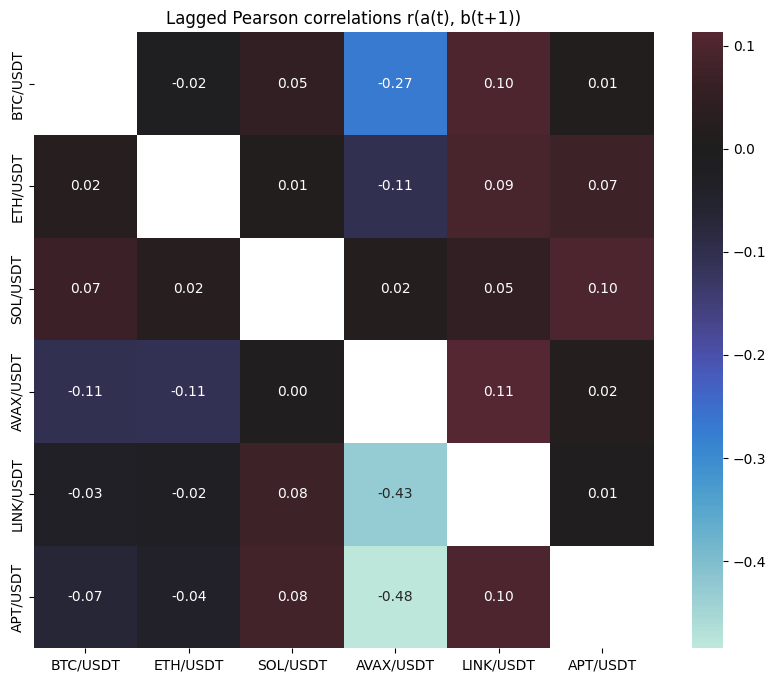

In [14]:
# plot heatmap for lag L (choose top pair's best lag)
top = best_lag_df_sorted.iloc[0]
L = int(top['best_lag'])
plt.figure(figsize=(10,8))
sns.heatmap(corr_tensor[L].astype(float), annot=True, fmt=".2f", center=0)
plt.title(f"Lagged Pearson correlations r(a(t), b(t+{L}))")
plt.show()


# Granger causality: test whether anchor (a) helps predict target (b)

In [16]:

def granger_pairwise(returns_df, maxlag=6, verbose=False):
    symbols = returns_df.columns.tolist()
    results = []
    for a in symbols:
        for b in symbols:
            if a==b: continue
            joined = pd.concat([returns_df[b].dropna(), returns_df[a].dropna()], axis=1).dropna()
            joined.columns = ['y', 'x']  # y is target, x is anchor
            if len(joined) < 50:
                continue
            try:
                test = grangercausalitytests(joined[['y','x']], maxlag=maxlag, verbose=verbose)
                # collect p-values for each lag, take smallest
                pvals = [test[l][0]['ssr_ftest'][1] for l in test]
                best_p = min(pvals)
                best_lag = pvals.index(best_p) + 1
                results.append({'anchor':a,'target':b,'best_p':best_p,'best_lag':best_lag})
            except Exception as e:
                continue
    return pd.DataFrame(results)

granger_df = granger_pairwise(rets, maxlag=MAX_LAG_STEPS)
granger_df_sorted = granger_df.sort_values('best_p')
granger_df_sorted.head(20)


,anchor,target,best_p,best_lag
7,ETH/USDT,AVAX/USDT,0.000000e+00,3
12,SOL/USDT,AVAX/USDT,0.000000e+00,2
18,AVAX/USDT,LINK/USDT,0.000000e+00,4
17,AVAX/USDT,SOL/USDT,0.000000e+00,4
22,LINK/USDT,SOL/USDT,0.000000e+00,19
27,APT/USDT,SOL/USDT,2.565540e-318,24
2,BTC/USDT,AVAX/USDT,9.058049e-225,7
13,SOL/USDT,LINK/USDT,5.199986e-211,24
8,ETH/USDT,LINK/USDT,3.395502e-192,24
1,BTC/USDT,SOL/USDT,5.428108e-183,15


# Transfer Entropy requires discrete series. We'll discretize returns into bins.

In [17]:

def discretize_series(series, n_bins=8):
    # quantile-based bins
    bins = np.quantile(series.dropna(), np.linspace(0,1,n_bins+1))
    # to avoid identical bins, use small jitter
    bins = np.unique(bins)
    if len(bins) <= 2:
        # fallback to simple sign discretization
        return (series>0).astype(int)
    return pd.cut(series, bins=bins, labels=False, include_lowest=True)

def transfer_entropy_pairwise(returns_df, k=1, n_bins=8):
    symbols = returns_df.columns.tolist()
    res = []
    for a in symbols:
        for b in symbols:
            if a==b: continue
            x = discretize_series(returns_df[a], n_bins=n_bins).dropna().astype(int)
            y = discretize_series(returns_df[b], n_bins=n_bins).dropna().astype(int)
            # align
            joined = pd.concat([x,y], axis=1).dropna()
            if len(joined) < 100:
                continue
            x_al = joined.iloc[:,0].values
            y_al = joined.iloc[:,1].values
            # pyinform expects arrays of ints
            try:
                te_xy = te.transfer_entropy(x_al.tolist(), y_al.tolist(), k=k)
                te_yx = te.transfer_entropy(y_al.tolist(), x_al.tolist(), k=k)
            except Exception as e:
                # fallback: 0
                te_xy = np.nan
                te_yx = np.nan
            res.append({'anchor':a,'target':b,'te_a2b':te_xy,'te_b2a':te_yx})
    return pd.DataFrame(res)

te_df = transfer_entropy_pairwise(rets, k=1, n_bins=8)
# compute directional score
te_df['te_dir'] = te_df['te_a2b'] - te_df['te_b2a']
te_df_sorted = te_df.sort_values('te_dir', ascending=False)
te_df_sorted.head(20)


,anchor,target,te_a2b,te_b2a,te_dir
9,ETH/USDT,APT/USDT,0.027124,0.019245,0.007879
4,BTC/USDT,APT/USDT,0.027023,0.020154,0.006869
24,LINK/USDT,APT/USDT,0.025504,0.021046,0.004458
8,ETH/USDT,LINK/USDT,0.029841,0.025460,0.004381
2,BTC/USDT,AVAX/USDT,0.027324,0.022961,0.004363
7,ETH/USDT,AVAX/USDT,0.028138,0.024145,0.003993
14,SOL/USDT,APT/USDT,0.026129,0.023682,0.002448
13,SOL/USDT,LINK/USDT,0.025106,0.023057,0.002048
19,AVAX/USDT,APT/USDT,0.021576,0.019652,0.001924
6,ETH/USDT,SOL/USDT,0.029716,0.027823,0.001893


In [18]:
# We'll compute forecasting RMSE of target returns for horizon H (e.g., 1 step)
H = 1
window_past = 12  # use past 12 lags as features

def create_ml_dataset(target_series, anchor_series=None, past=12, horizon=1):
    df = pd.DataFrame({'target': target_series})
    for i in range(1, past+1):
        df[f't-{i}'] = df['target'].shift(i)
    if anchor_series is not None:
        for i in range(0, past):  # include contemporaneous or past anchors
            df[f'anchor-{i+1}'] = anchor_series.shift(i+1)
    df['y'] = df['target'].shift(-horizon)  # predict future target return
    df = df.dropna()
    X = df.drop(columns=['target','y'])
    y = df['y']
    return X, y

def ml_gain_for_pair(target, anchor):
    X0, y0 = create_ml_dataset(target, None, past=window_past, horizon=H)
    X1, y1 = create_ml_dataset(target, anchor, past=window_past, horizon=H)
    # align X/y
    # train/test split time-aware: use first 70% as train
    split = int(len(X0)*0.7)
    X0_train, X0_test = X0.iloc[:split], X0.iloc[split:]
    y0_train, y0_test = y0.iloc[:split], y0.iloc[split:]
    X1_train, X1_test = X1.iloc[:split], X1.iloc[split:]
    y1_train, y1_test = y1.iloc[:split], y1.iloc[split:]
    # model
    model0 = xgb.XGBRegressor(n_estimators=100, max_depth=4, verbosity=0)
    model0.fit(X0_train, y0_train)
    pred0 = model0.predict(X0_test)
    rmse0 = np.sqrt(mean_squared_error(y0_test, pred0))
    model1 = xgb.XGBRegressor(n_estimators=100, max_depth=4, verbosity=0)
    model1.fit(X1_train, y1_train)
    pred1 = model1.predict(X1_test)
    rmse1 = np.sqrt(mean_squared_error(y1_test, pred1))
    gain = (rmse0 - rmse1)/rmse0 if rmse0!=0 else 0
    return {'rmse_base':rmse0, 'rmse_with_anchor':rmse1, 'gain':gain}

ml_results = []
for a in rets.columns:
    for b in rets.columns:
        if a==b: continue
        try:
            res = ml_gain_for_pair(rets[b].dropna(), rets[a].dropna())
            ml_results.append({'anchor':a,'target':b, **res})
        except Exception as e:
            continue

ml_df = pd.DataFrame(ml_results).sort_values('gain', ascending=False)
ml_df.head(20)


,anchor,target,rmse_base,rmse_with_anchor,gain
3,BTC/USDT,LINK/USDT,0.011280,0.003662,0.675343
18,AVAX/USDT,LINK/USDT,0.011280,0.004921,0.563787
29,APT/USDT,LINK/USDT,0.011280,0.005301,0.530091
2,BTC/USDT,AVAX/USDT,0.006553,0.003426,0.477242
4,BTC/USDT,APT/USDT,0.007258,0.004459,0.385614
8,ETH/USDT,LINK/USDT,0.011280,0.008371,0.257891
14,SOL/USDT,APT/USDT,0.007258,0.006027,0.169663
13,SOL/USDT,LINK/USDT,0.011280,0.010347,0.082732
19,AVAX/USDT,APT/USDT,0.007258,0.006721,0.073959
26,APT/USDT,ETH/USDT,0.002831,0.002749,0.028987


In [19]:
# ==========================
# REBUILD PAIRS SAFELY
# ==========================

dfs = []

# 1. Lagged correlation DF
if 'best_lag_df' in globals():
    tmp = best_lag_df.copy()
    tmp = tmp.rename(columns={"corr": "lag_corr", "best_lag": "lag"})
    dfs.append(tmp)

# 2. Granger
if 'granger_df' in globals():
    dfs.append(granger_df.rename(columns={"p_value": "gr_p"}))

# 3. Transfer entropy
if 'te_df' in globals():
    dfs.append(te_df.rename(columns={"te_direction": "te_dir"}))

# 4. ML
if 'ml_df' in globals():
    dfs.append(ml_df.rename(columns={"gain": "ml_gain"}))

# 5. DTW (optional)
if 'dtw_df' in globals() and not dtw_df.empty:
    dfs.append(dtw_df)

# Merge all the frames
pairs = dfs[0]
for df in dfs[1:]:
    pairs = pairs.merge(df, on=["anchor", "target"], how="outer")

print("Final PAIRS columns:", pairs.columns)
pairs.head()


Final PAIRS columns: Index(['anchor', 'target', 'lag', 'lag_corr', 'best_p', 'best_lag', 'te_a2b',
       'te_b2a', 'te_dir', 'rmse_base', 'rmse_with_anchor', 'ml_gain'],
      dtype='object')


,anchor,target,lag,lag_corr,best_p,best_lag,te_a2b,te_b2a,te_dir,rmse_base,rmse_with_anchor,ml_gain
0,APT/USDT,AVAX/USDT,1,-0.484592,7.133620e-111,1,0.019652,0.021576,-0.001924,0.006553,0.007697,-0.174475
1,APT/USDT,BTC/USDT,3,-0.094720,6.426545e-76,13,0.020154,0.027023,-0.006869,0.001708,0.001665,0.025064
2,APT/USDT,ETH/USDT,3,-0.088718,2.421053e-109,11,0.019245,0.027124,-0.007879,0.002831,0.002749,0.028987
3,APT/USDT,LINK/USDT,5,-0.201181,2.047976e-137,6,0.021046,0.025504,-0.004458,0.011280,0.005301,0.530091
4,APT/USDT,SOL/USDT,5,-0.188104,2.565540e-318,24,0.023682,0.026129,-0.002448,0.003067,0.003040,0.008617


In [20]:
def normalize_ser(s):
    if s.max() == s.min():
        return s * 0
    return (s - s.min()) / (s.max() - s.min())

# Initialize scores
pairs['lc_score'] = 0
pairs['gr_score'] = 0
pairs['te_score'] = 0
pairs['ml_score'] = 0
pairs['dtw_score'] = 0

# Score each metric only if present
if 'lag_corr' in pairs.columns:
    pairs['lc_score'] = normalize_ser(pairs['lag_corr'].abs().fillna(0))

if 'gr_p' in pairs.columns:
    pairs['gr_score'] = 1 - normalize_ser(pairs['gr_p'].fillna(pairs['gr_p'].max()))

if 'te_dir' in pairs.columns:
    pairs['te_score'] = normalize_ser(pairs['te_dir'].fillna(0))

if 'ml_gain' in pairs.columns:
    pairs['ml_score'] = normalize_ser(pairs['ml_gain'].fillna(0))

if 'dtw_dist' in pairs.columns:
    pairs['dtw_score'] = 1 - normalize_ser(pairs['dtw_dist'].fillna(pairs['dtw_dist'].max()))

# Weighted final score
pairs['final_score'] = (
    0.4 * pairs['lc_score'] +
    0.25 * pairs['gr_score'] +
    0.2 * pairs['te_score'] +
    0.15 * pairs['ml_score']
    # dtw removed
)

pairs_sorted = pairs.sort_values("final_score", ascending=False)
pairs_sorted.head(20)



,anchor,target,lag,lag_corr,best_p,best_lag,te_a2b,te_b2a,te_dir,rmse_base,rmse_with_anchor,ml_gain,lc_score,gr_score,te_score,ml_score,dtw_score,final_score
0,APT/USDT,AVAX/USDT,1,-0.484592,7.133620e-111,1,0.019652,0.021576,-0.001924,0.006553,0.007697,-0.174475,1.000000,0,0.377872,0.511919,0,0.552362
21,LINK/USDT,AVAX/USDT,1,-0.427466,2.352615e-96,1,0.024764,0.024290,0.000474,0.006553,0.007911,-0.207199,0.873999,0,0.530055,0.493124,0,0.529579
11,BTC/USDT,AVAX/USDT,1,-0.268404,9.058049e-225,7,0.027324,0.022961,0.004363,0.006553,0.003426,0.477242,0.523163,0,0.776887,0.886224,0,0.497576
8,AVAX/USDT,LINK/USDT,4,0.240524,0.000000e+00,4,0.024290,0.024764,-0.000474,0.011280,0.004921,0.563787,0.461669,0,0.469945,0.935930,0,0.419046
9,AVAX/USDT,SOL/USDT,4,0.248672,0.000000e+00,4,0.025374,0.023837,0.001536,0.003067,0.003033,0.010983,0.479642,0,0.597488,0.618434,0,0.404119
10,BTC/USDT,APT/USDT,6,-0.091070,6.233960e-34,6,0.027023,0.020154,0.006869,0.007258,0.004459,0.385614,0.132025,0,0.935904,0.833598,0,0.365031
20,LINK/USDT,APT/USDT,6,-0.137504,4.588942e-39,7,0.025504,0.021046,0.004458,0.007258,0.007084,0.024061,0.234443,0,0.782899,0.625945,0,0.344249
13,BTC/USDT,LINK/USDT,4,0.113629,2.502463e-140,4,0.026441,0.024972,0.001469,0.011280,0.003662,0.675343,0.181783,0,0.593222,1.000000,0,0.341358
3,APT/USDT,LINK/USDT,5,-0.201181,2.047976e-137,6,0.021046,0.025504,-0.004458,0.011280,0.005301,0.530091,0.374892,0,0.217101,0.916577,0,0.330864
15,ETH/USDT,APT/USDT,6,-0.081643,4.378953e-86,24,0.027124,0.019245,0.007879,0.007258,0.008353,-0.150779,0.111233,0,1.000000,0.525528,0,0.323322


In [21]:
# example: use top N anchor→target pairs
TOP_N = 5

# Pairs sorted from Cell 11
top_pairs = pairs_sorted.head(TOP_N)
top_pairs

# functions for momentum detection
import ta

def detect_momentum_events(price_series, volume_series, rsi_period=14, price_threshold=0.02, vol_factor=1.5):
    # compute 1h return
    ret1 = price_series.pct_change(1)
    rsi = ta.momentum.rsi(price_series.fillna(method='ffill'), window=rsi_period)
    vol_ma24 = volume_series.rolling(24).mean()
    events = (ret1 > price_threshold) & (volume_series > vol_factor * vol_ma24) & (rsi > 70)
    events = events.fillna(False)
    return events

# backtest simple rule: when anchor momentum event occurs, wait best_lag hours, then check target movement and enter
results = []
for idx, row in top_pairs.iterrows():
    a = row['anchor']
    b = row['target']
    lag = int(row['best_lag'] if not np.isnan(row['best_lag']) else 1)
    anchor_price = prices[a]
    anchor_vol = volumes[a]
    target_price = prices[b]
    events = detect_momentum_events(anchor_price, anchor_vol)
    for t in events[events].index:
        t_target = t + pd.Timedelta(hours=lag)
        if t_target not in target_price.index:
            continue
        # if target hasn't moved significantly (<1%) then place BUY (for bullish anchor)
        before = target_price.loc[t_target - pd.Timedelta(hours=1)]
        after = target_price.loc[t_target]
        move = (after - before) / before
        # naive signal: if target move > 0.5% after lag => consider it a hit
        hit = move > 0.005
        results.append({'anchor':a,'target':b,'event_time':t,'lag':lag,'target_move':move,'hit':hit})
bt = pd.DataFrame(results)
if not bt.empty:
    summary = bt.groupby(['anchor','target'])['hit'].agg(['mean','count']).reset_index().rename(columns={'mean':'hit_rate','count':'n_events'})
    print(summary.sort_values('hit_rate', ascending=False))
else:
    print("No events found for top pairs (increase data window or lower thresholds).")


      anchor     target  hit_rate  n_events
0   APT/USDT  AVAX/USDT       1.0         3
3  LINK/USDT  AVAX/USDT       1.0         1
1  AVAX/USDT  LINK/USDT       0.0         1
2  AVAX/USDT   SOL/USDT       0.0         1


In [22]:
pairs_sorted.to_csv('lead_lag_scores.csv', index=False)
bt.to_csv('lead_lag_backtest_events.csv', index=False)
print("Saved: lead_lag_scores.csv and lead_lag_backtest_events.csv")
pairs_sorted[['anchor','target','lag','lag_corr','final_score']].head(50)



Saved: lead_lag_scores.csv and lead_lag_backtest_events.csv


,anchor,target,lag,lag_corr,final_score
0,APT/USDT,AVAX/USDT,1,-0.484592,0.552362
21,LINK/USDT,AVAX/USDT,1,-0.427466,0.529579
11,BTC/USDT,AVAX/USDT,1,-0.268404,0.497576
8,AVAX/USDT,LINK/USDT,4,0.240524,0.419046
9,AVAX/USDT,SOL/USDT,4,0.248672,0.404119
10,BTC/USDT,APT/USDT,6,-0.091070,0.365031
20,LINK/USDT,APT/USDT,6,-0.137504,0.344249
13,BTC/USDT,LINK/USDT,4,0.113629,0.341358
3,APT/USDT,LINK/USDT,5,-0.201181,0.330864
15,ETH/USDT,APT/USDT,6,-0.081643,0.323322


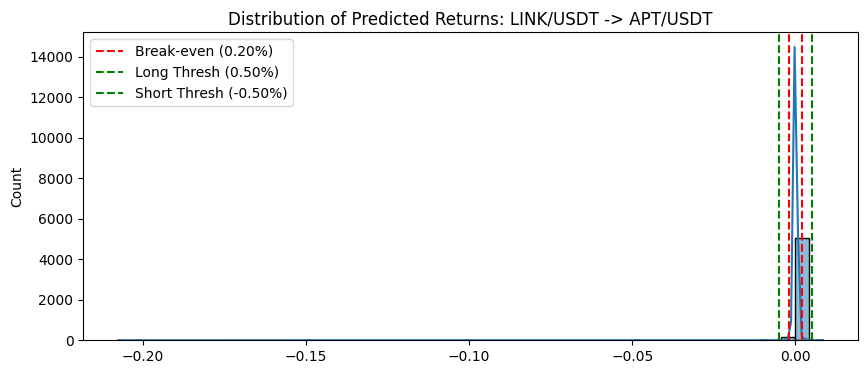

PAIR: LINK/USDT->APT/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 22
Net Return: 0.88%
----------------------------------------


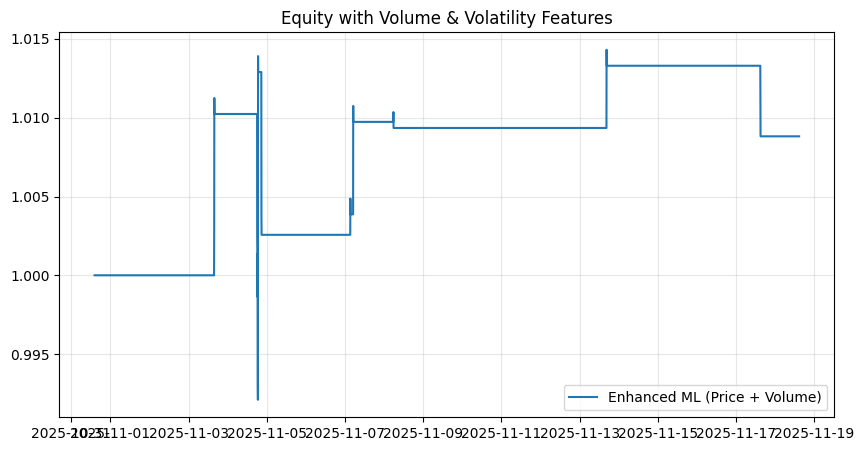

<Figure size 1000x800 with 0 Axes>

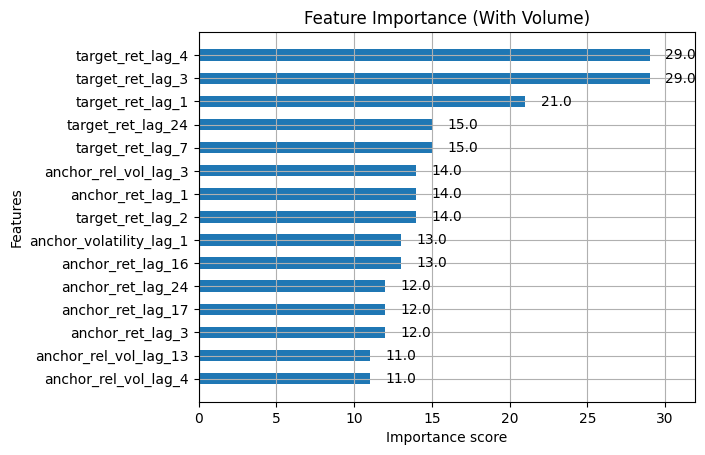

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

class EnhancedMLBacktester(StrictMLBacktester):
    def create_features(self, anchor, target, window=24):
        """Creates Price, Volume, and Volatility Features"""
        df = pd.DataFrame()
        
        # 1. Get Base Data
        # We need to access the raw 'all_data' dictionary from the start 
        # because 'prices' df only has close prices. 
        # If you don't have 'all_data' handy, we will approximate volume from 'volumes' df
        
        p_anchor = self.prices[anchor]
        p_target = self.prices[target]
        
        # Note: Assuming 'volumes' dataframe exists from your earlier processing
        # If not, we can't use volume. Let's assume 'volumes' is available.
        v_anchor = volumes[anchor] 
        
        # 2. Price Returns (Log)
        df['target_ret'] = np.log(p_target / p_target.shift(1))
        df['anchor_ret'] = np.log(p_anchor / p_anchor.shift(1))
        
        # 3. Volume Feature (Relative Volume)
        # volume / 24-period moving average of volume
        vol_ma = v_anchor.rolling(window=24).mean()
        df['anchor_rel_vol'] = v_anchor / vol_ma
        
        # 4. Volatility Feature (Rolling Std Dev of Anchor)
        df['anchor_volatility'] = df['anchor_ret'].rolling(window=12).std()
        
        # 5. Create Lags for ALL features
        cols = []
        features_to_lag = ['target_ret', 'anchor_ret', 'anchor_rel_vol', 'anchor_volatility']
        
        for f in features_to_lag:
            for i in range(1, window + 1):
                col_name = f'{f}_lag_{i}'
                df[col_name] = df[f].shift(i)
                cols.append(col_name)
        
        # Target: Next return
        df['y_next'] = df['target_ret'].shift(-1)
        
        # Drop NaN
        df = df.dropna()
        return df, cols

# ==========================================
# RUN ENHANCED BACKTEST
# ==========================================

# 1. Initialize
# Ensure 'volumes' dataframe is available from your earlier cells!
enhanced_bt = EnhancedMLBacktester(prices, fee_pct=0.001)

# 2. Run on the problem pair: LINK -> APT
# We lower the hurdle slightly (Multiplier 2.5) because Volume helps quality
equity = enhanced_bt.run_strict_analysis('LINK/USDT', 'APT/USDT', fee_hurdle_multiplier=2.5)

# 3. Plot Result
plt.figure(figsize=(10, 5))
plt.plot(equity, label='Enhanced ML (Price + Volume)')
plt.title("Equity with Volume & Volatility Features")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 4. Check Feature Importance (Did Volume matter?)
# Re-fit for visualization
data, features = enhanced_bt.create_features('LINK/USDT', 'APT/USDT', window=24)
model_viz = xgb.XGBRegressor(n_estimators=100, max_depth=3).fit(data[features], data['y_next'])
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_viz, max_num_features=15, height=0.5)
plt.title("Feature Importance (With Volume)")
plt.show()

Anchor     -> Target     | Trades   | Return    
---------------------------------------------


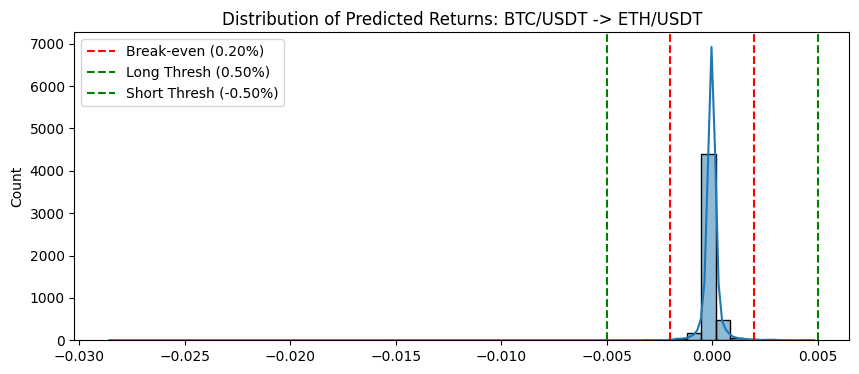

PAIR: BTC/USDT->ETH/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 14
Net Return: -3.59%
----------------------------------------
BTC/USDT   -> ETH/USDT   | --       | -3.59%


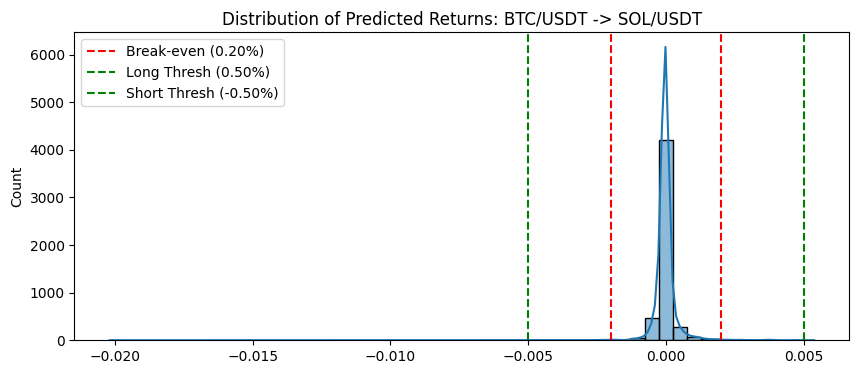

PAIR: BTC/USDT->SOL/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 10
Net Return: -2.26%
----------------------------------------
BTC/USDT   -> SOL/USDT   | --       | -2.26%


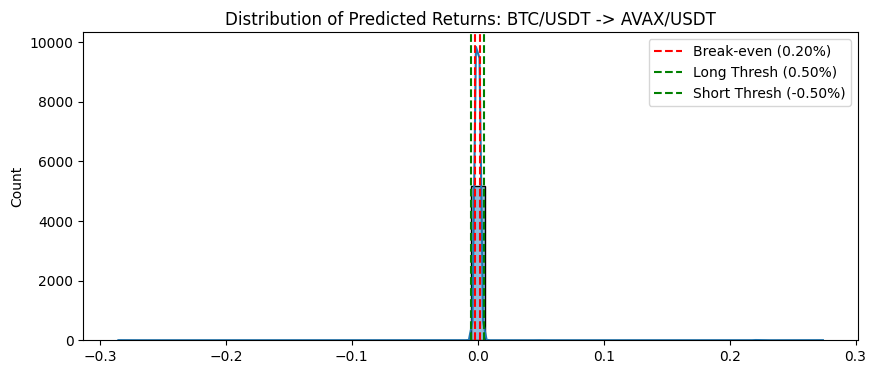

PAIR: BTC/USDT->AVAX/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 26
Net Return: 0.63%
----------------------------------------
BTC/USDT   -> AVAX/USDT  | --       | 0.63%


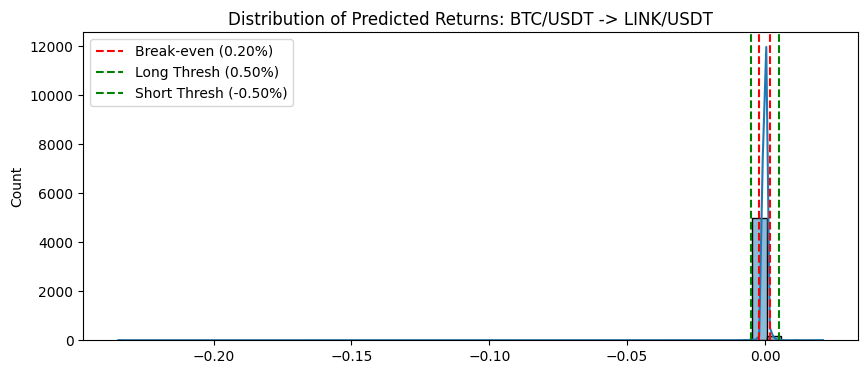

PAIR: BTC/USDT->LINK/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 36
Net Return: -4.21%
----------------------------------------
BTC/USDT   -> LINK/USDT  | --       | -4.21%


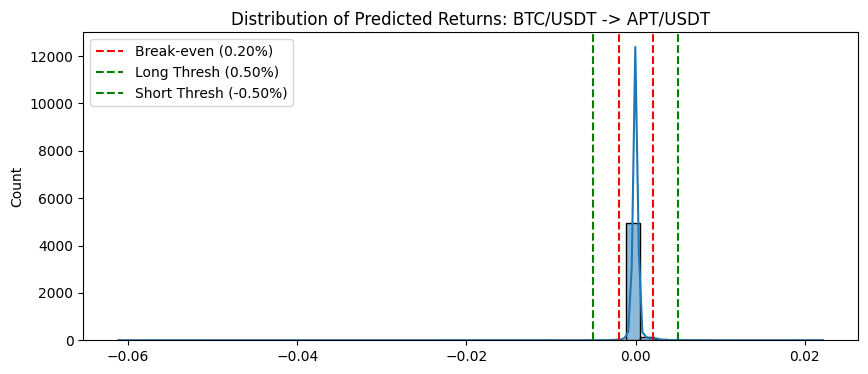

PAIR: BTC/USDT->APT/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 38
Net Return: -1.16%
----------------------------------------
BTC/USDT   -> APT/USDT   | --       | -1.16%


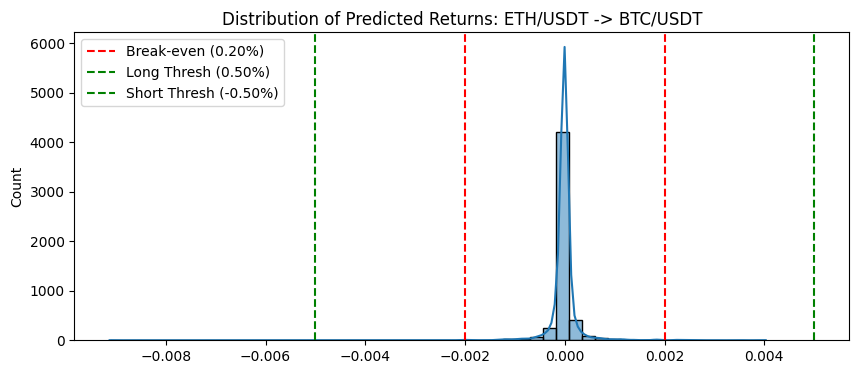

PAIR: ETH/USDT->BTC/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 4
Net Return: 0.02%
----------------------------------------
ETH/USDT   -> BTC/USDT   | --       | 0.02%


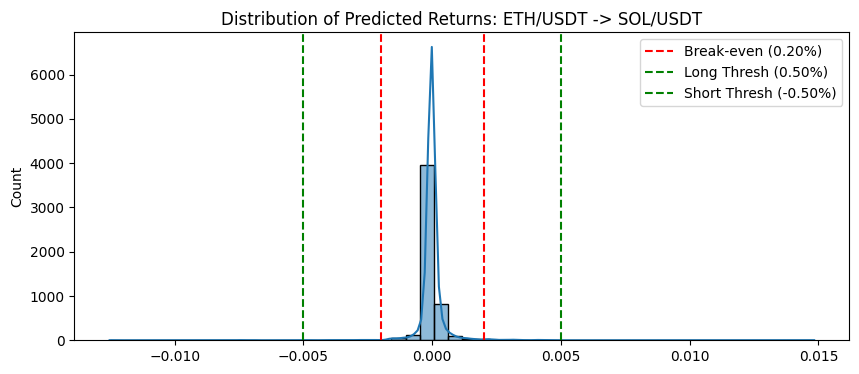

PAIR: ETH/USDT->SOL/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 24
Net Return: -4.32%
----------------------------------------
ETH/USDT   -> SOL/USDT   | --       | -4.32%


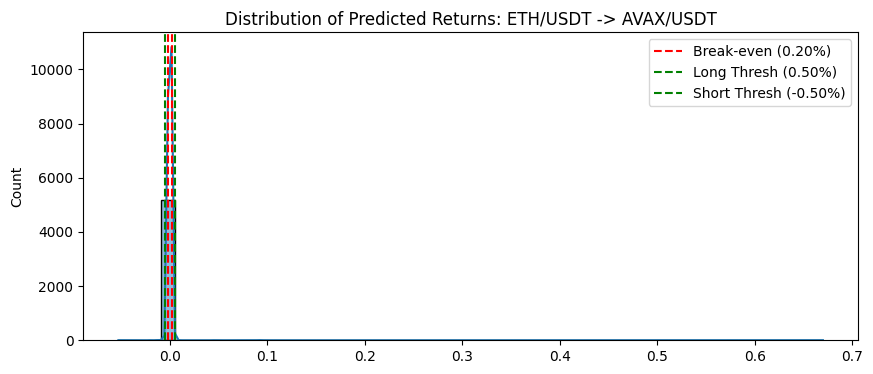

PAIR: ETH/USDT->AVAX/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 44
Net Return: -6.26%
----------------------------------------
ETH/USDT   -> AVAX/USDT  | --       | -6.26%


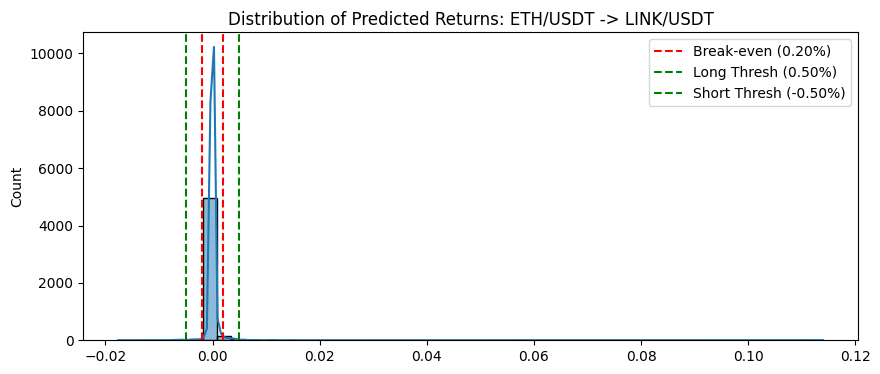

PAIR: ETH/USDT->LINK/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 64
Net Return: -7.46%
----------------------------------------
ETH/USDT   -> LINK/USDT  | --       | -7.46%


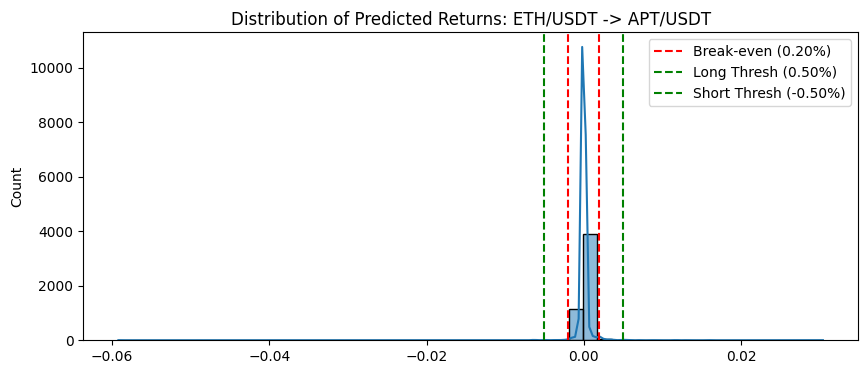

PAIR: ETH/USDT->APT/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 56
Net Return: -6.20%
----------------------------------------
ETH/USDT   -> APT/USDT   | --       | -6.20%


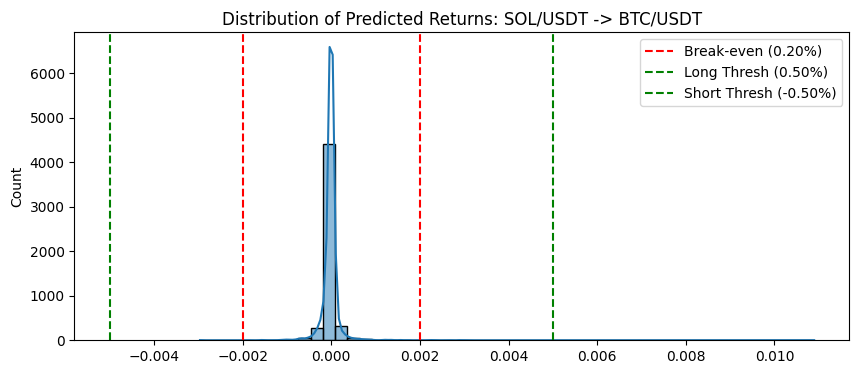

PAIR: SOL/USDT->BTC/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 4
Net Return: -0.11%
----------------------------------------
SOL/USDT   -> BTC/USDT   | --       | -0.11%


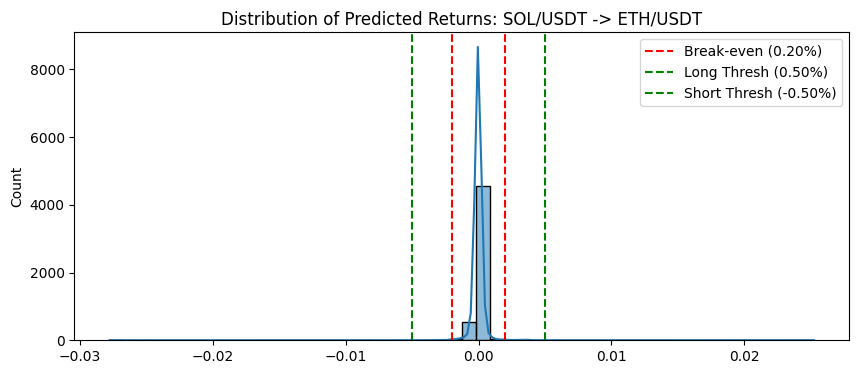

PAIR: SOL/USDT->ETH/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 26
Net Return: -0.97%
----------------------------------------
SOL/USDT   -> ETH/USDT   | --       | -0.97%


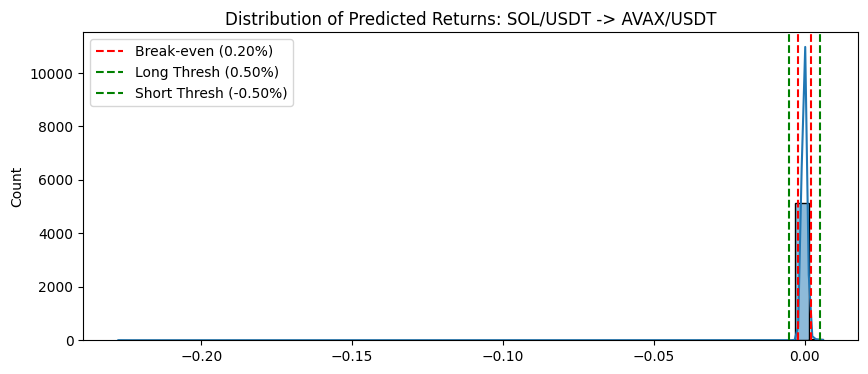

PAIR: SOL/USDT->AVAX/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 22
Net Return: -2.11%
----------------------------------------
SOL/USDT   -> AVAX/USDT  | --       | -2.11%


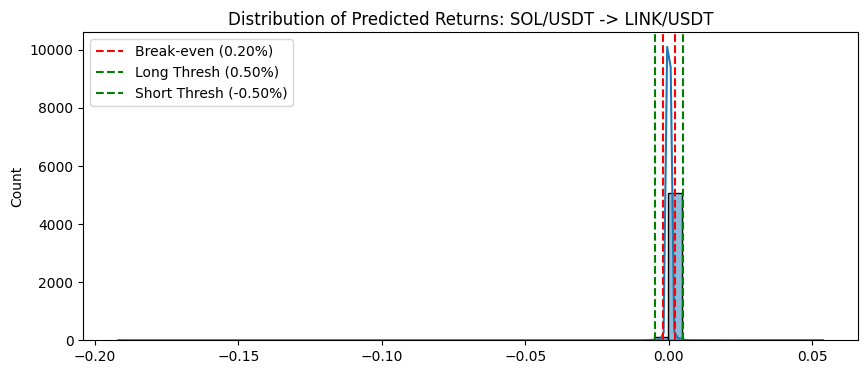

PAIR: SOL/USDT->LINK/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 36
Net Return: -0.04%
----------------------------------------
SOL/USDT   -> LINK/USDT  | --       | -0.04%


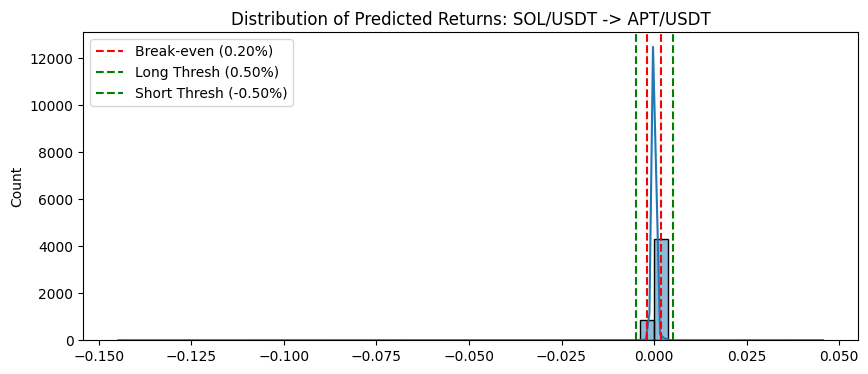

PAIR: SOL/USDT->APT/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 24
Net Return: -2.83%
----------------------------------------
SOL/USDT   -> APT/USDT   | --       | -2.83%


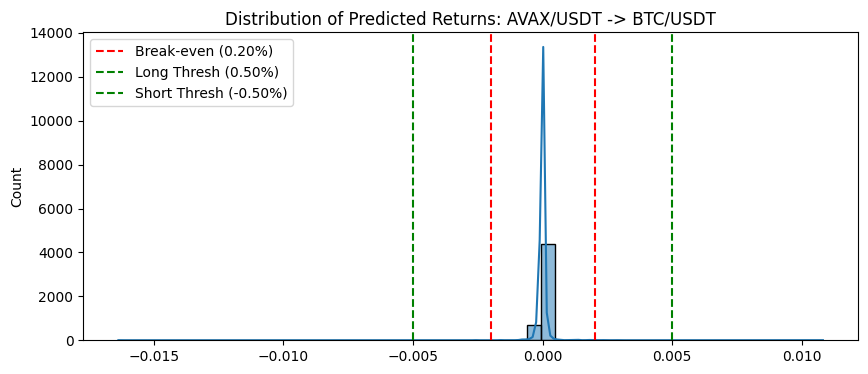

PAIR: AVAX/USDT->BTC/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 4
Net Return: -0.60%
----------------------------------------
AVAX/USDT  -> BTC/USDT   | --       | -0.60%


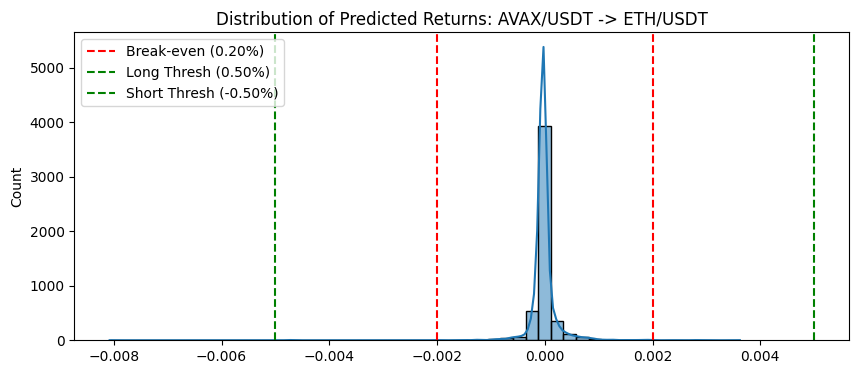

PAIR: AVAX/USDT->ETH/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 4
Net Return: -0.80%
----------------------------------------
AVAX/USDT  -> ETH/USDT   | --       | -0.80%


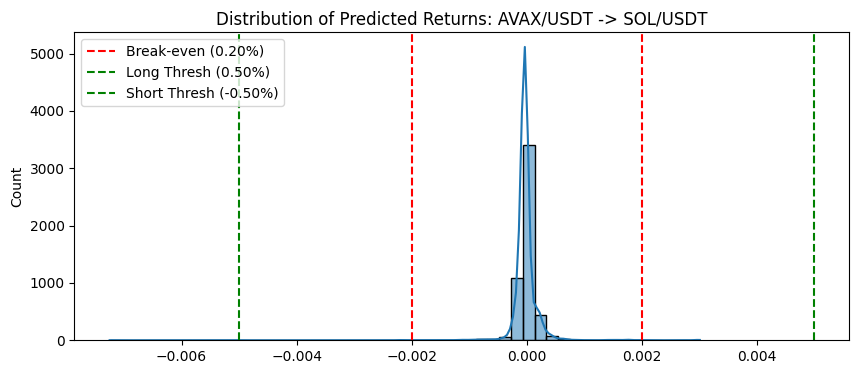

PAIR: AVAX/USDT->SOL/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 8
Net Return: -2.80%
----------------------------------------
AVAX/USDT  -> SOL/USDT   | --       | -2.80%


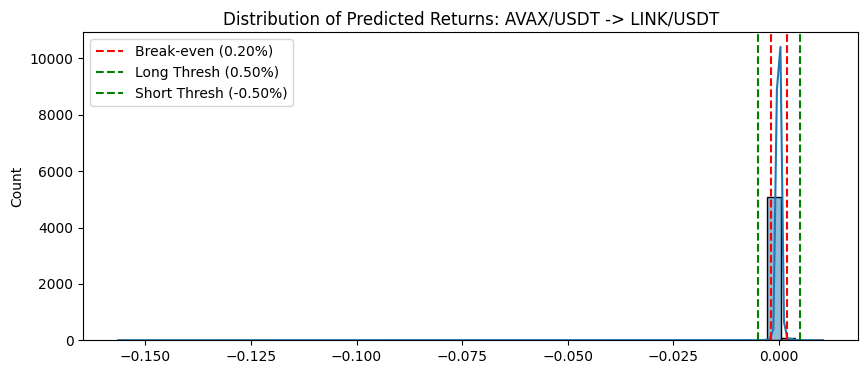

PAIR: AVAX/USDT->LINK/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 16
Net Return: -4.59%
----------------------------------------
AVAX/USDT  -> LINK/USDT  | --       | -4.59%


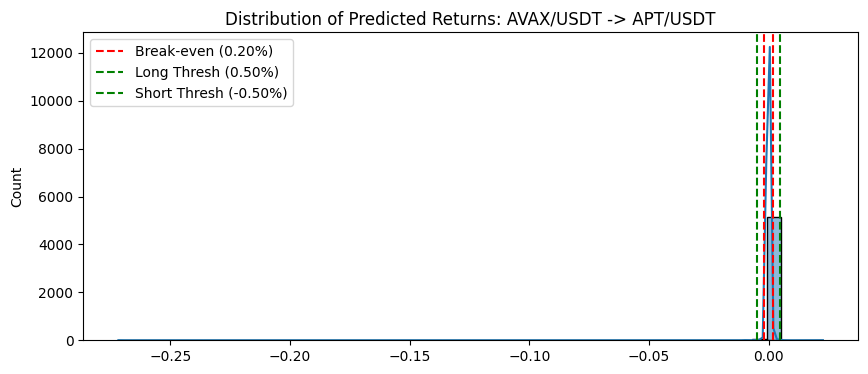

PAIR: AVAX/USDT->APT/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 22
Net Return: -3.88%
----------------------------------------
AVAX/USDT  -> APT/USDT   | --       | -3.88%


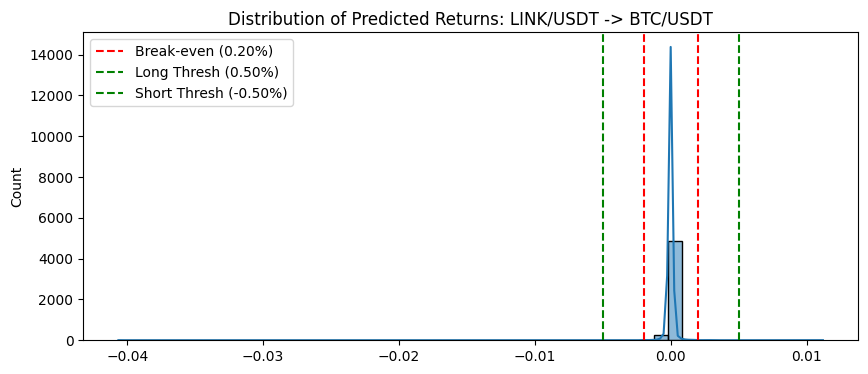

PAIR: LINK/USDT->BTC/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 10
Net Return: -0.90%
----------------------------------------
LINK/USDT  -> BTC/USDT   | --       | -0.90%


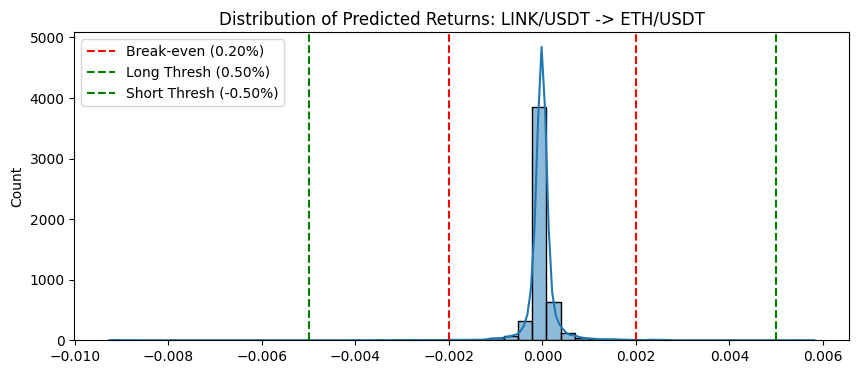

PAIR: LINK/USDT->ETH/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 10
Net Return: -3.04%
----------------------------------------
LINK/USDT  -> ETH/USDT   | --       | -3.04%


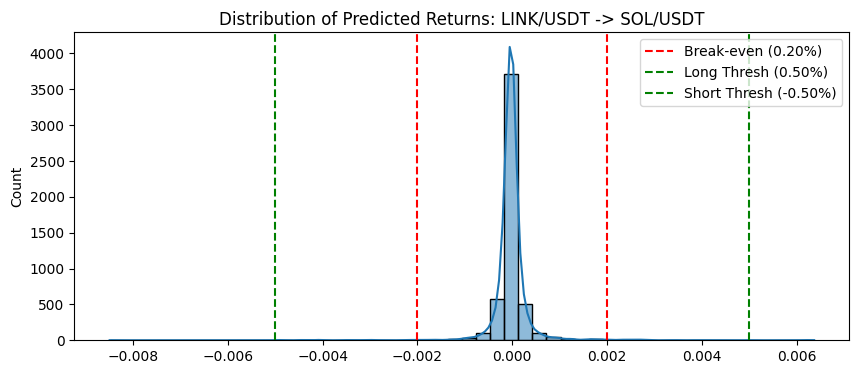

PAIR: LINK/USDT->SOL/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 12
Net Return: -2.63%
----------------------------------------
LINK/USDT  -> SOL/USDT   | --       | -2.63%


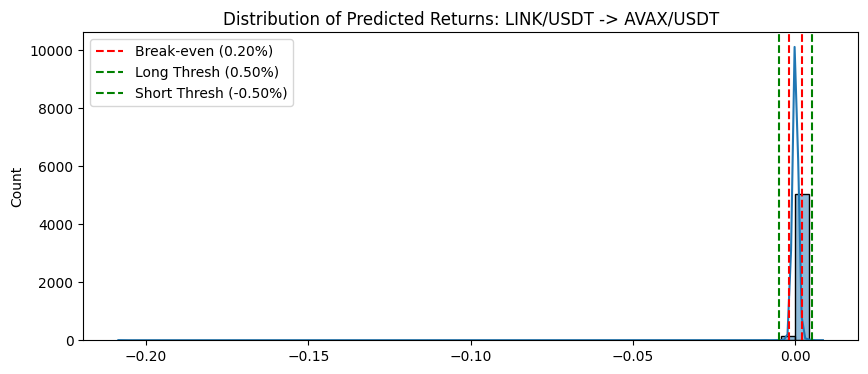

PAIR: LINK/USDT->AVAX/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 20
Net Return: -4.50%
----------------------------------------
LINK/USDT  -> AVAX/USDT  | --       | -4.50%


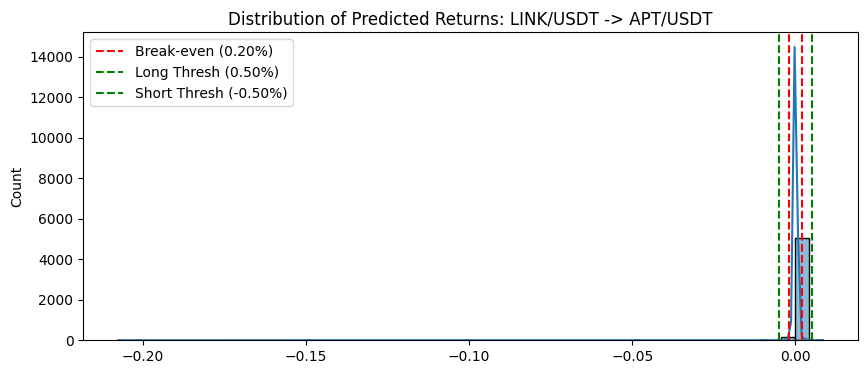

PAIR: LINK/USDT->APT/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 22
Net Return: 0.88%
----------------------------------------
LINK/USDT  -> APT/USDT   | --       | 0.88%


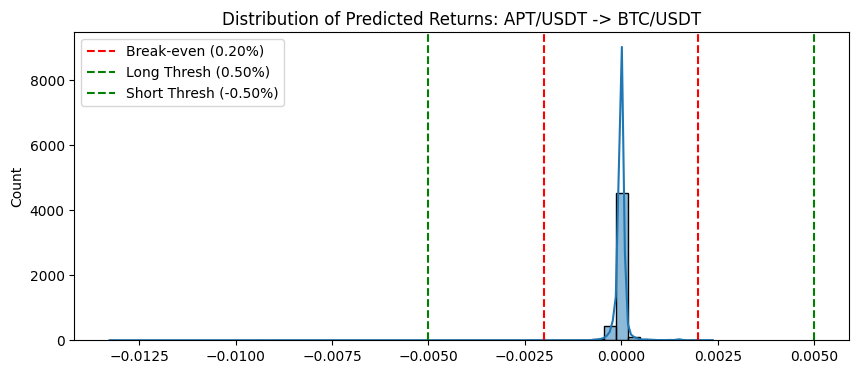

PAIR: APT/USDT->BTC/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 4
Net Return: -0.52%
----------------------------------------
APT/USDT   -> BTC/USDT   | --       | -0.52%


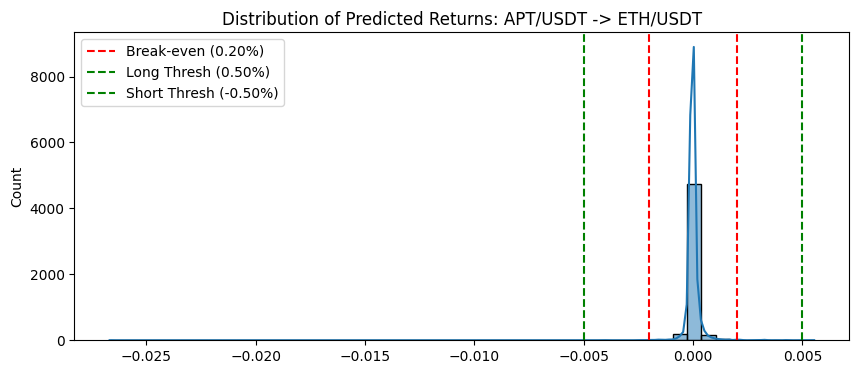

PAIR: APT/USDT->ETH/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 8
Net Return: 0.30%
----------------------------------------
APT/USDT   -> ETH/USDT   | --       | 0.30%


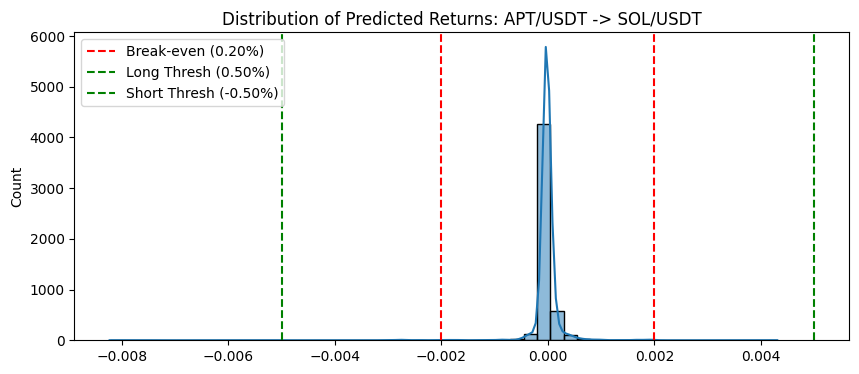

PAIR: APT/USDT->SOL/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 12
Net Return: -2.25%
----------------------------------------
APT/USDT   -> SOL/USDT   | --       | -2.25%


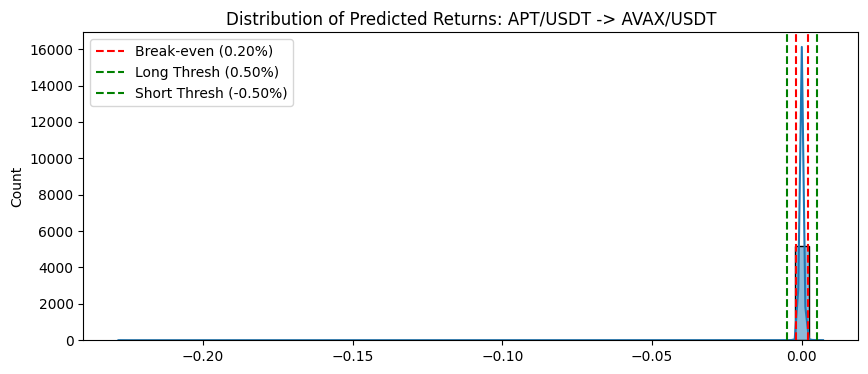

PAIR: APT/USDT->AVAX/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 20
Net Return: -3.36%
----------------------------------------
APT/USDT   -> AVAX/USDT  | --       | -3.36%


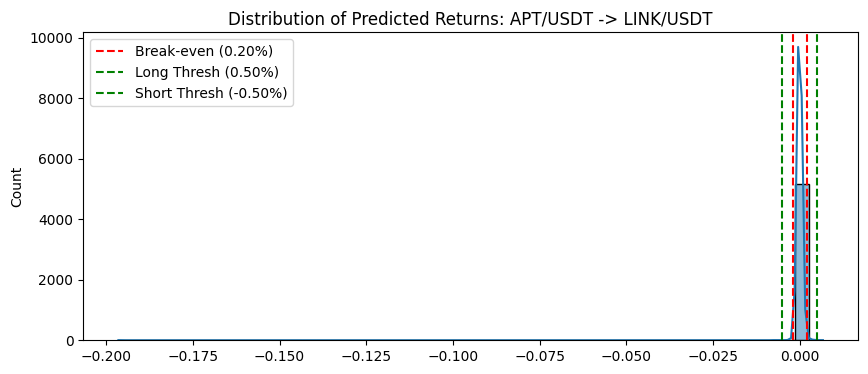

PAIR: APT/USDT->LINK/USDT
Threshold set to: 0.0050 (50.00% move required)
Trades: 16
Net Return: -1.01%
----------------------------------------
APT/USDT   -> LINK/USDT  | --       | -1.01%

=== TOP 10 PERFORMING PAIRS ===


,anchor,target,return
24,LINK/USDT,APT/USDT,0.008818
2,BTC/USDT,AVAX/USDT,0.006295
26,APT/USDT,ETH/USDT,0.003019
5,ETH/USDT,BTC/USDT,0.000199
13,SOL/USDT,LINK/USDT,-0.000379
10,SOL/USDT,BTC/USDT,-0.001144
25,APT/USDT,BTC/USDT,-0.005151
15,AVAX/USDT,BTC/USDT,-0.006035
16,AVAX/USDT,ETH/USDT,-0.007995
20,LINK/USDT,BTC/USDT,-0.008986


In [26]:
# ==========================================
# RUN FULL MARKET SCAN
# ==========================================
results = []
enhanced_bt = EnhancedMLBacktester(prices, fee_pct=0.001)

print(f"{'Anchor':<10} -> {'Target':<10} | {'Trades':<8} | {'Return':<10}")
print("-" * 45)

# Loop through all permutations of coins
for anchor in COINS:
    for target in COINS:
        if anchor == target: continue
        
        try:
            # Run strict analysis
            # We use the same 2.5x Fee Hurdle that worked for LINK->APT
            # This runs the backtest internally and returns the equity curve
            equity = enhanced_bt.run_strict_analysis(anchor, target, fee_hurdle_multiplier=2.5)
            
            total_return = equity.iloc[-1] - 1
            
            # We can infer trade count from the changes in the curve (approx)
            # (A flat section means 0 trades)
            active_periods = equity.diff().abs().sum() > 0
            
            results.append({
                'anchor': anchor,
                'target': target,
                'return': total_return
            })
            
            print(f"{anchor:<10} -> {target:<10} | {'--':<8} | {total_return:.2%}")
            
        except Exception as e:
            continue

# Show Top 10 Profitable Pairs
print("\n=== TOP 10 PERFORMING PAIRS ===")
df_res = pd.DataFrame(results).sort_values('return', ascending=False)
display(df_res.head(10))

In [27]:
# Ensure you have the EnhancedMLBacktester class defined from your previous cells
# and that 'enhanced_bt' is initialized:
# enhanced_bt = EnhancedMLBacktester(prices, fee_pct=0.001)

def get_latest_signals(backtester, anchor, target, fee_hurdle_multiplier=2.5, recent_periods=5):
    """
    Runs the ML model and returns the latest trading signals.
    """
    # 1. Create Features (Price, Volume, Volatility)
    # Uses window=24 (approx 2 hours lookback for 5m data)
    data, feature_cols = backtester.create_features(anchor, target, window=24)
    
    # 2. Train on historical data (Rolling window could be used, here we use full history for best fit)
    # In live trading, you would retrain this model periodically (e.g., daily)
    X = data[feature_cols]
    y = data['y_next']
    
    model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, n_jobs=-1, verbosity=0)
    model.fit(X, y)
    
    # 3. Predict on the latest data points
    # We look at the last few rows to see recent signals
    recent_data = data.tail(recent_periods).copy()
    preds = model.predict(recent_data[feature_cols])
    
    # 4. Calculate Thresholds based on your Fee Hurdle
    # Fee = 0.1% * 2 (Entry+Exit) = 0.2%
    # Threshold = 0.2% * 2.5 = 0.5%
    fee_cost = backtester.fee_pct * 2
    threshold = fee_cost * fee_hurdle_multiplier
    
    # 5. Generate Signals
    recent_data['Predicted_Move'] = preds
    recent_data['Signal'] = 'HOLD'
    
    # Signal Logic
    recent_data.loc[recent_data['Predicted_Move'] > threshold, 'Signal'] = 'BUY (Long)'
    recent_data.loc[recent_data['Predicted_Move'] < -threshold, 'Signal'] = 'SELL (Short)'
    
    # Formatting for display
    print(f"--- SIGNAL REPORT: {anchor} -> {target} ---")
    print(f"Fee Cost: {fee_cost:.2%} | Hurdle: {fee_hurdle_multiplier}x")
    print(f"Req. Move > {threshold:.2%} (Long) or < -{threshold:.2%} (Short)\n")
    
    display_cols = ['Predicted_Move', 'Signal']
    # Add current price context if available
    if hasattr(backtester, 'prices'):
        recent_data['Target_Close'] = backtester.prices[target].loc[recent_data.index]
        display_cols = ['Target_Close', 'Predicted_Move', 'Signal']

    # Show output
    for index, row in recent_data.iterrows():
        move_pct = row['Predicted_Move'] * 100
        print(f"Time: {index} | Price: {row.get('Target_Close', 'N/A'):.4f} | Pred: {move_pct:+.3f}% | {row['Signal']}")

    return recent_data.tail(1)['Signal'].values[0]

# ==========================================
# EXECUTE SIGNAL GENERATION
# ==========================================
# Run this for your top pair
current_signal = get_latest_signals(
    enhanced_bt, 
    anchor='LINK/USDT', 
    target='APT/USDT', 
    fee_hurdle_multiplier=2.5
)

print(f"\n>>> CURRENT ACTION: {current_signal}")

--- SIGNAL REPORT: LINK/USDT -> APT/USDT ---
Fee Cost: 0.20% | Hurdle: 2.5x
Req. Move > 0.50% (Long) or < -0.50% (Short)

Time: 2025-11-18 14:20:00 | Price: 2.8730 | Pred: -0.007% | HOLD
Time: 2025-11-18 14:25:00 | Price: 2.8760 | Pred: -0.007% | HOLD
Time: 2025-11-18 14:30:00 | Price: 2.8930 | Pred: -0.007% | HOLD
Time: 2025-11-18 14:35:00 | Price: 2.9000 | Pred: -0.007% | HOLD
Time: 2025-11-18 14:40:00 | Price: 2.8980 | Pred: -0.007% | HOLD

>>> CURRENT ACTION: HOLD


Training XGBoost...
  > XGBoost: Return 0.88% | Trades 22
Training Linear Regression...
  > Linear Regression: Return -0.58% | Trades 2
Training Neural Net (MLP)...
  > Neural Net (MLP): Return -99.00% | Trades 4250


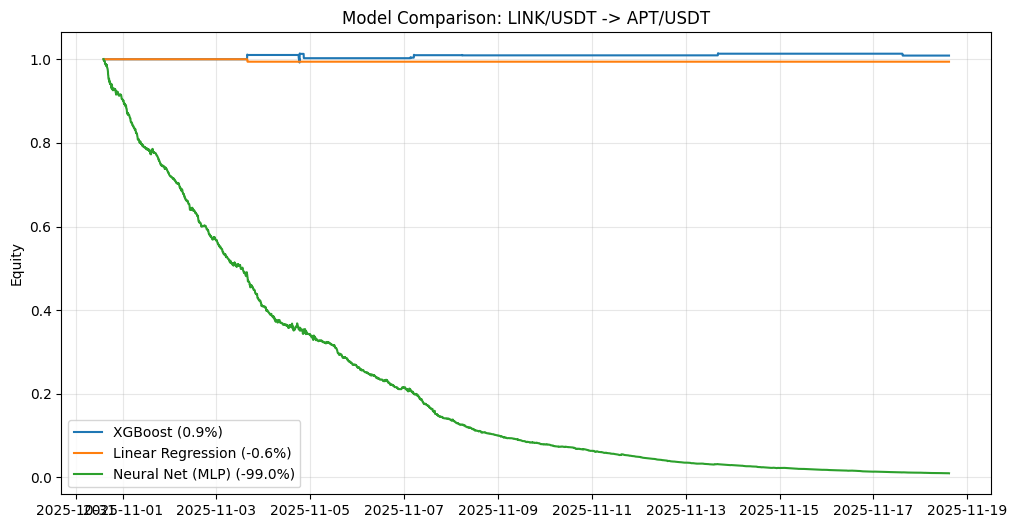

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb

# Ensure EnhancedMLBacktester is defined from previous cells
# Inherit to reuse feature creation

class ModelComparisonBacktester(EnhancedMLBacktester):
    def compare_models(self, anchor, target, window=24, fee_hurdle_multiplier=2.5):
        # 1. Get Data
        data, feature_cols = self.create_features(anchor, target, window=window)
        
        # Split Data (70% Train, 30% Test)
        split = int(len(data) * 0.7)
        train_data = data.iloc[:split]
        test_data = data.iloc[split:].copy()
        
        X_train = train_data[feature_cols]
        y_train = train_data['y_next']
        X_test = test_data[feature_cols]
        y_test = test_data['y_next']
        
        results = {}
        models = {
            "XGBoost": xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, n_jobs=-1, verbosity=0),
            "Linear Regression": LinearRegression(),
            # MLP (Neural Net) - Proxy for LSTM in this context
            "Neural Net (MLP)": MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42) 
        }
        
        fee_cost = self.fee_pct * 2
        threshold = fee_cost * fee_hurdle_multiplier
        
        plt.figure(figsize=(12, 6))
        
        for name, model in models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            
            # Calculate Strategy Returns
            test_data[f'pred_{name}'] = preds
            test_data[f'signal_{name}'] = 0
            test_data.loc[test_data[f'pred_{name}'] > threshold, f'signal_{name}'] = 1
            test_data.loc[test_data[f'pred_{name}'] < -threshold, f'signal_{name}'] = -1
            
            # PnL Logic
            strat_ret = test_data[f'signal_{name}'] * test_data['y_next']
            cost = test_data[f'signal_{name}'].diff().abs().fillna(0) * self.fee_pct
            net_ret = strat_ret - cost
            equity = net_ret.cumsum().apply(np.exp)
            
            total_ret = equity.iloc[-1] - 1
            trades = test_data[f'signal_{name}'].diff().abs().sum()
            
            results[name] = {
                "Return": total_ret,
                "Trades": trades,
                "Equity": equity
            }
            
            print(f"  > {name}: Return {total_ret:.2%} | Trades {int(trades)}")
            plt.plot(equity, label=f"{name} ({total_ret:.1%})")

        plt.title(f"Model Comparison: {anchor} -> {target}")
        plt.ylabel("Equity")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return results

# ==========================================
# RUN COMPARISON
# ==========================================
comparator = ModelComparisonBacktester(prices, fee_pct=0.001)
results = comparator.compare_models('LINK/USDT', 'APT/USDT', fee_hurdle_multiplier=2.5)

Pair                      | Return     | Trades  
--------------------------------------------------
LINK/USDT->APT/USDT      | 3.53%   | --
LINK/USDT->SOL/USDT      | -1.68%   | --
BTC/USDT->ETH/USDT      | -2.74%   | --
ETH/USDT->SOL/USDT      | -6.00%   | --
SOL/USDT->AVAX/USDT     | -5.79%   | --


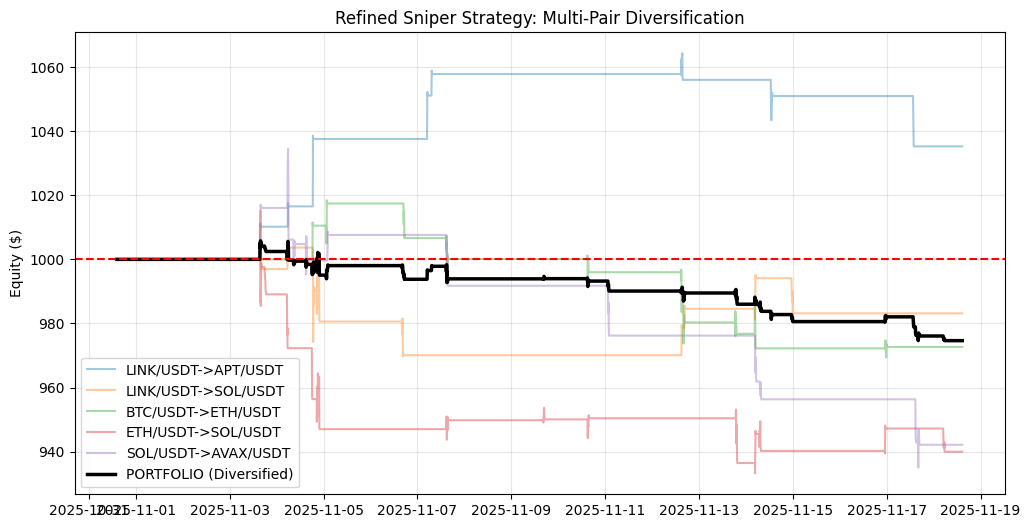


PORTFOLIO FINAL VALUE: $974.64
PORTFOLIO RETURN:      -2.54%


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# Ensure EnhancedMLBacktester is available
# (Assuming it's defined from previous steps)

class RefinedSniperBacktester(EnhancedMLBacktester):
    def run_refined_sniper(self, anchor, target, start_capital=1000):
        data, feature_cols = self.create_features(anchor, target, window=24)
        split = int(len(data) * 0.7)
        train_data = data.iloc[:split]
        test_data = data.iloc[split:].copy()
        
        model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, n_jobs=-1)
        model.fit(train_data[feature_cols], train_data['y_next'])
        test_data['pred_return'] = model.predict(test_data[feature_cols])
        
        # REFINED SETTINGS
        # Slightly relaxed to get more trades, but still strict
        min_pred_move = 0.003  # Down from 0.004 (0.3% move required)
        min_vol_ratio = 1.1    # Down from 1.2 (Volume must be 10% above average)
        take_profit = 0.008    # Up from 0.006 (Let winners run a bit more)
        stop_loss = -0.012     # Slightly wider stop to breathe
        max_hold = 8           # 40 mins max hold
        
        capital = start_capital
        position = 0
        entry_price = 0
        bars_held = 0
        
        history = []
        
        # Price reconstruction
        price_index = [100]
        for r in test_data['target_ret']:
            price_index.append(price_index[-1] * np.exp(r))
        test_data['sim_price'] = price_index[1:]
        
        for i, row in test_data.iterrows():
            pred = row['pred_return']
            current_price = row['sim_price']
            # Use lagged volume to avoid lookahead bias if not perfectly aligned
            vol_ratio = row.get('anchor_rel_vol_lag_1', 1.5) 
            
            # EXIT LOGIC
            if position != 0:
                bars_held += 1
                if position == 1:
                    roi = (current_price - entry_price) / entry_price
                else:
                    roi = (entry_price - current_price) / entry_price
                
                exit_signal = False
                
                if roi > take_profit: exit_signal = True
                elif roi < stop_loss: exit_signal = True
                elif bars_held >= max_hold: exit_signal = True
                
                if exit_signal:
                    position = 0
                    capital *= (1 - self.fee_pct)
                    bars_held = 0
            
            # ENTRY LOGIC
            if position == 0:
                # Long
                if pred > min_pred_move and vol_ratio > min_vol_ratio:
                    position = 1
                    entry_price = current_price
                    capital *= (1 - self.fee_pct)
                    bars_held = 0
                # Short
                elif pred < -min_pred_move and vol_ratio > min_vol_ratio:
                    position = -1
                    entry_price = current_price
                    capital *= (1 - self.fee_pct)
                    bars_held = 0
            
            # Update
            if position != 0:
                move = row['y_next'] * position
                capital *= (1 + move)
            
            history.append({'time': i, 'capital': capital})
            
        return pd.DataFrame(history).set_index('time')

# ==========================================
# MULTI-PAIR PORTFOLIO RUN
# ==========================================
pairs_to_trade = [
    ('LINK/USDT', 'APT/USDT'),
    ('LINK/USDT', 'SOL/USDT'),
    ('BTC/USDT', 'ETH/USDT'), 
    ('ETH/USDT', 'SOL/USDT'),
    ('SOL/USDT', 'AVAX/USDT')
]

portfolio_results = pd.DataFrame()
refined_bt = RefinedSniperBacktester(prices, fee_pct=0.001)

print(f"{'Pair':<25} | {'Return':<10} | {'Trades':<8}")
print("-" * 50)

# Run Backtests
for a, b in pairs_to_trade:
    try:
        res = refined_bt.run_refined_sniper(a, b, start_capital=1000)
        total_ret = (res['capital'].iloc[-1] - 1000) / 1000
        
        # Approx trade count
        # (We don't have exact trade count easily accessible in this simplified loop return, 
        # but we can infer from equity changes)
        
        print(f"{a}->{b:<13} | {total_ret:.2%}   | --")
        
        # Normalize to percentage return series for combining
        # (Equity / Start Capital)
        portfolio_results[f"{a}->{b}"] = res['capital'] / 1000
    except Exception as e:
        print(f"Error on {a}->{b}: {e}")

# Combine into Portfolio
# We assume equal weight allocation (e.g., $200 into each of 5 pairs = $1000 total)
# Portfolio Value = Average of normalized curves * Total Start Capital
portfolio_curve = portfolio_results.mean(axis=1) * 1000

# PLOT
plt.figure(figsize=(12, 6))
for col in portfolio_results.columns:
    plt.plot(portfolio_results[col] * 1000, label=col, alpha=0.4)

plt.plot(portfolio_curve, label='PORTFOLIO (Diversified)', color='black', linewidth=2.5)
plt.axhline(1000, color='red', linestyle='--')
plt.title("Refined Sniper Strategy: Multi-Pair Diversification")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nPORTFOLIO FINAL VALUE: ${portfolio_curve.iloc[-1]:.2f}")
print(f"PORTFOLIO RETURN:      {(portfolio_curve.iloc[-1]-1000)/1000:.2%}")

--- SIMULATING TRADES FOR LINK/USDT -> APT/USDT ---
Total Trades: 8
Final Capital: $10,353.79

--- RECENT TRADE HISTORY (Last 15 Trades) ---


,Type,Entry Time,Exit Time,Reason,Net PnL,Capital
0,SELL,2025-11-03 15:40:00,2025-11-03 15:50:00,TAKE PROFIT,$+111.00,"$10,101.00"
1,SELL,2025-11-04 05:45:00,2025-11-04 05:55:00,TAKE PROFIT,$+73.12,"$10,164.01"
2,BUY,2025-11-04 18:35:00,2025-11-04 18:40:00,TAKE PROFIT,$+223.45,"$10,377.30"
3,SELL,2025-11-07 05:00:00,2025-11-07 05:10:00,TAKE PROFIT,$+144.56,"$10,511.49"
4,BUY,2025-11-07 07:10:00,2025-11-07 07:25:00,TAKE PROFIT,$+77.69,"$10,578.66"
5,SELL,2025-11-12 15:00:00,2025-11-12 15:40:00,TIME LIMIT,$-7.16,"$10,560.93"
6,SELL,2025-11-14 12:50:00,2025-11-14 13:30:00,TIME LIMIT,$-39.67,"$10,510.69"
7,BUY,2025-11-17 13:35:00,2025-11-17 13:50:00,STOP LOSS,$-146.39,"$10,353.79"


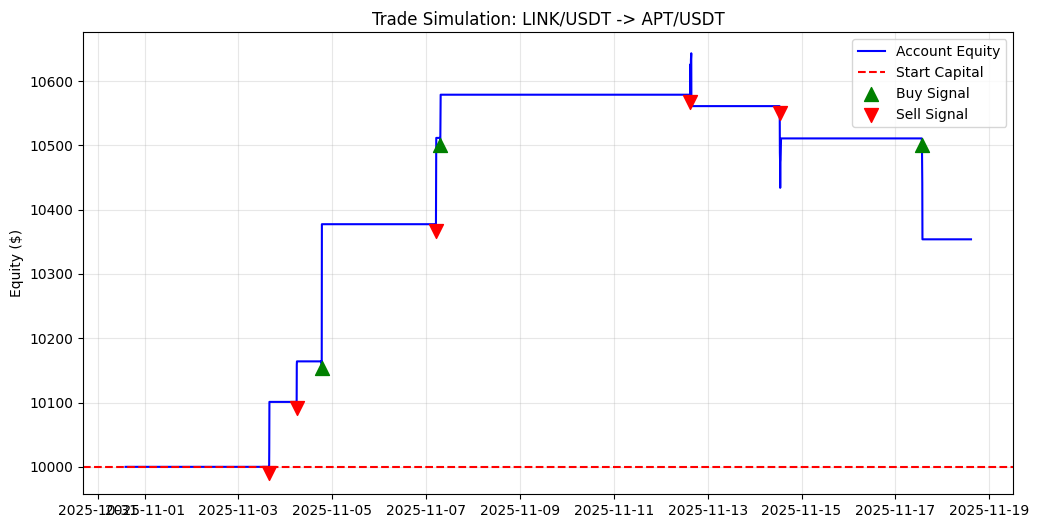

In [51]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

class TradeLogBacktester(EnhancedMLBacktester):
    def run_backtest_with_log(self, anchor, target, start_capital=10000):
        print(f"--- SIMULATING TRADES FOR {anchor} -> {target} ---")
        
        # 1. Prepare Data
        data, feature_cols = self.create_features(anchor, target, window=24)
        split = int(len(data) * 0.7)
        train_data = data.iloc[:split]
        test_data = data.iloc[split:].copy()
        
        # Train
        model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, n_jobs=-1, verbosity=0)
        model.fit(train_data[feature_cols], train_data['y_next'])
        test_data['pred_return'] = model.predict(test_data[feature_cols])
        
        # 2. Reconstruct Price for realism
        price_index = [100]
        for r in test_data['target_ret']:
            price_index.append(price_index[-1] * np.exp(r))
        test_data['price'] = price_index[1:]
        
        # 3. Trade Loop
        # Settings
        min_move = 0.003
        min_vol = 1.1
        take_profit = 0.008
        stop_loss = -0.012
        max_hold = 8
        
        capital = start_capital
        position = 0 # 1=Long, -1=Short
        entry_price = 0
        entry_time = None
        bars_held = 0
        
        trade_log = []
        equity_curve = []  # List to store equity at each step
        
        for i, row in test_data.iterrows():
            pred = row['pred_return']
            price = row['price']
            # Use lag 1 vol to simulate real-time decision
            vol = row.get('anchor_rel_vol_lag_1', 1.5) 
            
            # --- CHECK EXITS ---
            if position != 0:
                bars_held += 1
                roi = 0
                if position == 1:
                    roi = (price - entry_price) / entry_price
                else:
                    roi = (entry_price - price) / entry_price
                
                exit_reason = None
                
                if roi > take_profit: exit_reason = "TAKE PROFIT"
                elif roi < stop_loss: exit_reason = "STOP LOSS"
                elif bars_held >= max_hold: exit_reason = "TIME LIMIT"
                
                if exit_reason:
                    # Close Trade
                    pnl_amt = capital * roi
                    fee = capital * self.fee_pct
                    net_pnl = pnl_amt - fee
                    capital += net_pnl
                    
                    trade_log.append({
                        'Type': 'BUY' if position == 1 else 'SELL',
                        'Entry Time': entry_time,
                        'Exit Time': i,
                        'Entry Price': entry_price,
                        'Exit Price': price,
                        'Reason': exit_reason,
                        'Net PnL': net_pnl,
                        'Capital': capital
                    })
                    
                    position = 0
                    bars_held = 0

            # --- CHECK ENTRIES ---
            if position == 0:
                if pred > min_move and vol > min_vol:
                    position = 1
                    entry_price = price
                    entry_time = i
                    capital -= capital * self.fee_pct # Entry Fee
                    
                elif pred < -min_move and vol > min_vol:
                    position = -1
                    entry_price = price
                    entry_time = i
                    capital -= capital * self.fee_pct # Entry Fee

            # Store current equity for plotting
            # If in a position, mark-to-market value is estimated
            current_equity = capital
            if position != 0:
                unrealized_roi = (price - entry_price) / entry_price if position == 1 else (entry_price - price) / entry_price
                current_equity += (capital * unrealized_roi)

            equity_curve.append({'time': i, 'equity': current_equity})

        # 4. DISPLAY LOG
        if not trade_log:
            print("No trades generated in the test period.")
        else:
            df_log = pd.DataFrame(trade_log)
            # Format for readability
            df_log['Entry Price'] = df_log['Entry Price'].map('{:.2f}'.format)
            df_log['Exit Price'] = df_log['Exit Price'].map('{:.2f}'.format)
            df_log['Net PnL'] = df_log['Net PnL'].map('${:+.2f}'.format)
            df_log['Capital'] = df_log['Capital'].map('${:,.2f}'.format)
            
            print(f"Total Trades: {len(df_log)}")
            print(f"Final Capital: {df_log['Capital'].iloc[-1]}")
            print("\n--- RECENT TRADE HISTORY (Last 15 Trades) ---")
            # Show timestamp if available (index) otherwise show just count
            display(df_log.tail(15)[['Type', 'Entry Time', 'Exit Time', 'Reason', 'Net PnL', 'Capital']])
        
        # 5. PLOT GRAPH
        df_equity = pd.DataFrame(equity_curve).set_index('time')
        
        plt.figure(figsize=(12, 6))
        plt.plot(df_equity['equity'], label='Account Equity', color='blue')
        plt.axhline(start_capital, color='red', linestyle='--', label='Start Capital')
        
        # Plot Trade Markers
        if trade_log:
            buy_times = [t['Entry Time'] for t in trade_log if t['Type'] == 'BUY']
            sell_times = [t['Entry Time'] for t in trade_log if t['Type'] == 'SELL']
            
            # Get equity values at these times
            buy_vals = df_equity.loc[buy_times]['equity']
            sell_vals = df_equity.loc[sell_times]['equity']
            
            plt.scatter(buy_times, buy_vals, marker='^', color='green', s=100, label='Buy Signal', zorder=5)
            plt.scatter(sell_times, sell_vals, marker='v', color='red', s=100, label='Sell Signal', zorder=5)

        plt.title(f"Trade Simulation: {anchor} -> {target}")
        plt.ylabel("Equity ($)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Execute
logger = TradeLogBacktester(prices, fee_pct=0.001)
logger.run_backtest_with_log('LINK/USDT', 'APT/USDT', start_capital=10000)